# Fake or real Job Classification
- Data Shape: rows: 17880, columns: 17
- Missing data Percentage: 27.84%

- Goal : Classify Real or Fake job applications

- Evaluation Metric: ROC - AUC




# Results

Best Model: XGBoost Classfier

Best Mean Cross Validation Score is 0.9577
Best Mean Cross Validation Score is {'learning_rate': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
Train score is 0.9688
Test score is 0.9666

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
# from feature-engine
from feature_engine import missing_data_imputers as mdi
# for one hot encoding with feature-engine
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from feature_engine.categorical_encoders import RareLabelCategoricalEncoder
from sklearn.pipeline import Pipeline as skpipe

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from  sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from  sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier

# Data Loading and Exploration

In [4]:
# load data

data=pd.read_csv('fake_job_postings.csv')

In [5]:
df=data.copy()

In [5]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
job_id                 17880 non-null int64
title                  17880 non-null object
location               17534 non-null object
department             6333 non-null object
salary_range           2868 non-null object
company_profile        14572 non-null object
description            17879 non-null object
requirements           15185 non-null object
benefits               10670 non-null object
telecommuting          17880 non-null int64
has_company_logo       17880 non-null int64
has_questions          17880 non-null int64
employment_type        14409 non-null object
required_experience    10830 non-null object
required_education     9775 non-null object
industry               12977 non-null object
function               11425 non-null object
fraudulent             17880 non-null int64
dtypes: int64(5), object(13)
memory usage: 2.5+ MB


In [7]:
data.shape

(17880, 18)

## Missing values in Data set

In [8]:
# calculate null values

data.isnull().sum()/len(data)

job_id                 0.000000
title                  0.000000
location               0.019351
department             0.645805
salary_range           0.839597
company_profile        0.185011
description            0.000056
requirements           0.150727
benefits               0.403244
telecommuting          0.000000
has_company_logo       0.000000
has_questions          0.000000
employment_type        0.194128
required_experience    0.394295
required_education     0.453300
industry               0.274217
function               0.361018
fraudulent             0.000000
dtype: float64

## Output variable imbalance rate

In [12]:
data['fraudulent'].value_counts()/len(data['fraudulent'])

0    0.951566
1    0.048434
Name: fraudulent, dtype: float64

## Data Exploration

In [14]:
categorical=['department','employment_type','industry','function','required_experience',
             'required_education','has_company_logo','has_questions','telecommuting']

for var in categorical:
    data[var]=data[var].astype('object')

In [18]:
categorical=[var for var in data.columns if data[var].dtype=='O' ]
temporal=[var for var in data.columns if 'Yr' in var or 'Year' in var or 'year' in var and var not in categorical]
discrete=[var for var in data.columns if var not in temporal and var not in categorical and data[var].nunique()<11]
continuous=[var for var in data.columns if var not in temporal and var not in categorical and var not in discrete]
print(f'There are {len(data.columns)}  variable in data set ')
print(f'There are {len(categorical)} categorical variable in data set ')
print(f'There are {len(temporal)} temporal variable in data set ')
print(f'There are {len(discrete)} discrete variable in data set ')
print(f'There are {len(continuous)} continuous variable in data set')

There are 10  variable in data set 
There are 9 categorical variable in data set 
There are 0 temporal variable in data set 
There are 1 discrete variable in data set 
There are 0 continuous variable in data set


In [24]:
def checkcol(df,list):
    for var in list:
        print(f'There are {df[var].nunique()} unique values in the {var} variable')
        print(f'for variable {var} there are {round (100*df[var].isnull().sum()/len(df),2)} % values are missing')
        print(var,df[var].unique()[0:20],'\n')

In [25]:
checkcol(data,categorical)

There are 1337 unique values in the department variable
for variable department there are 64.58 % values are missing
department ['Marketing' 'Success' nan 'Sales' 'ANDROIDPIT' 'HR' ' R&D' 'Engagement'
 'Businessfriend.com' 'Medical' 'Field' 'All' 'Design' 'Production' 'ICM'
 'General Services' 'Engineering' 'IT' 'Business Development'
 'Human Resources'] 

There are 2 unique values in the telecommuting variable
for variable telecommuting there are 0.0 % values are missing
telecommuting [0 1] 

There are 2 unique values in the has_company_logo variable
for variable has_company_logo there are 0.0 % values are missing
has_company_logo [1 0] 

There are 2 unique values in the has_questions variable
for variable has_questions there are 0.0 % values are missing
has_questions [0 1] 

There are 5 unique values in the employment_type variable
for variable employment_type there are 19.41 % values are missing
employment_type ['Other' 'Full-time' nan 'Part-time' 'Contract' 'Temporary'] 

There are

In [19]:
100*data['department'].value_counts()

Sales                                                                                                                                                                                                                                                              55100
Engineering                                                                                                                                                                                                                                                        48700
Marketing                                                                                                                                                                                                                                                          40100
Operations                                                                                                                                                                                                   

In [20]:
data['function'].value_counts()/len(data['function'])

Information Technology    0.097819
Sales                     0.082103
Engineering               0.075391
Customer Service          0.068736
Marketing                 0.046421
Administrative            0.035235
Design                    0.019016
Health Care Provider      0.018904
Education                 0.018177
Other                     0.018177
Management                0.017729
Business Development      0.012752
Accounting/Auditing       0.011857
Human Resources           0.011465
Project Management        0.010235
Finance                   0.009620
Consulting                0.008054
Writing/Editing           0.007383
Art/Creative              0.007383
Production                0.006488
Product Management        0.006376
Quality Assurance         0.006208
Advertising               0.005034
Business Analyst          0.004698
Data Analyst              0.004586
Public Relations          0.004251
Manufacturing             0.004139
General Business          0.003803
Research            

In [21]:
data['industry'].value_counts()/len(data['industry'])

Information Technology and Services    0.096980
Computer Software                      0.076957
Internet                               0.059396
Marketing and Advertising              0.046309
Education Management                   0.045973
Financial Services                     0.043568
Hospital & Health Care                 0.027796
Consumer Services                      0.020022
Telecommunications                     0.019128
Oil & Energy                           0.016051
Retail                                 0.012472
Real Estate                            0.009787
Accounting                             0.008893
Construction                           0.008837
E-Learning                             0.007774
Management Consulting                  0.007271
Design                                 0.007215
Staffing and Recruiting                0.007103
Health, Wellness and Fitness           0.007103
Insurance                              0.006879
Automotive                             0

In [52]:
data['employment_type'].value_counts()/len(data['employment_type'])

Full-time    0.649888
Contract     0.085235
Part-time    0.044575
Temporary    0.013479
Other        0.012696
Name: employment_type, dtype: float64

# Location with maximum fake job posting

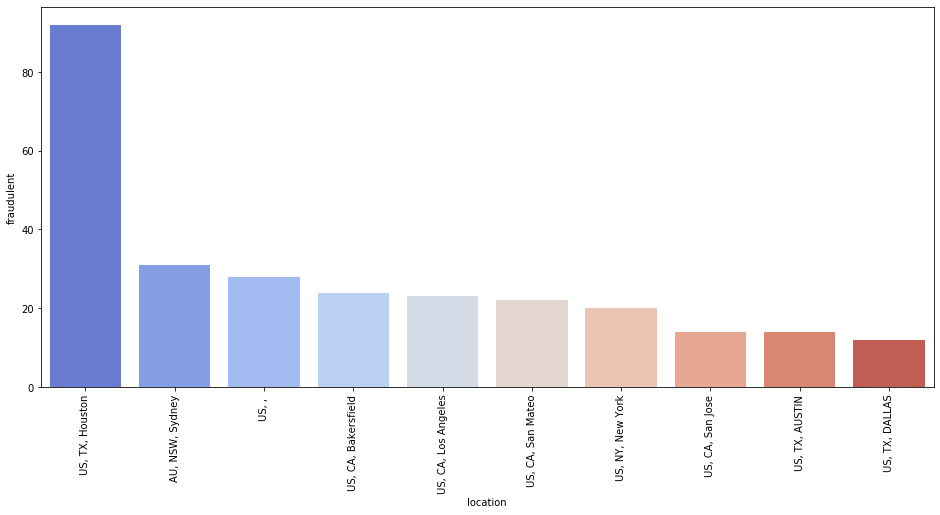

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,7))
ax.set_xticklabels(s, rotation='vertical')
s=data.loc[data['fraudulent']==1].groupby('location')['fraudulent'].count().sort_values(ascending=False)
s=s.head(10)
sns.barplot(x=s.index,y=s, palette='coolwarm',ax=ax)


# Which Employment Type has the maximum Fake job listings

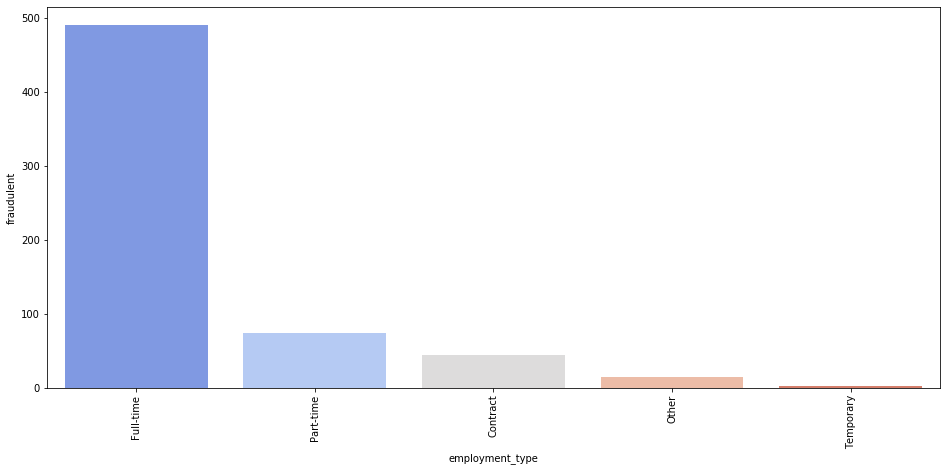

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,7))
ax.set_xticklabels(s, rotation='vertical')
s=data.loc[data['fraudulent']==1].groupby('employment_type')['fraudulent'].count().sort_values(ascending=False)

sns.barplot(x=s.index,y=s, palette='coolwarm',ax=ax)


# Which Industry has maximum Fake job listings

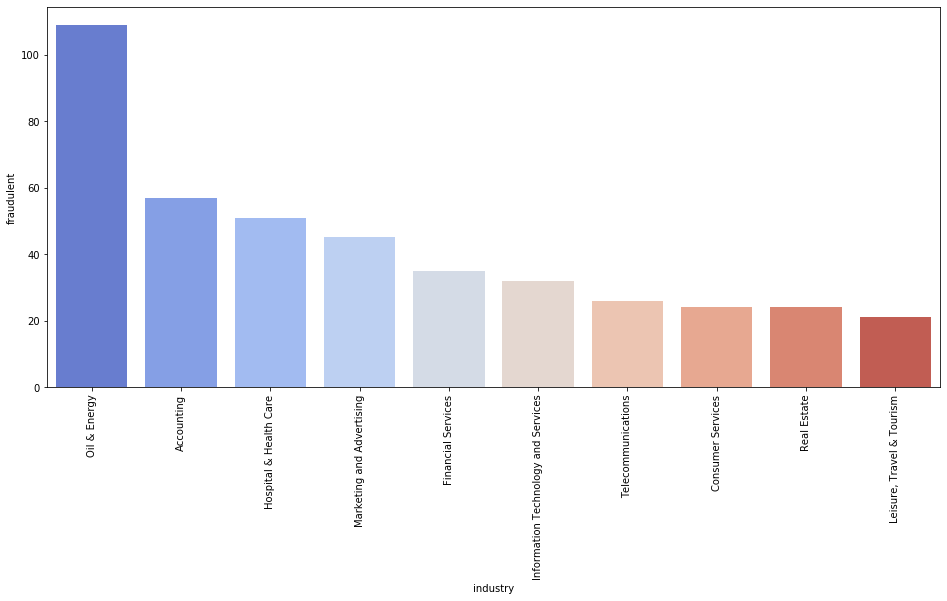

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,7))
ax.set_xticklabels(s, rotation='vertical')
s=data.loc[data['fraudulent']==1].groupby('industry')['fraudulent'].count().sort_values(ascending=False)
s=s.head(10)
#print(s,'\n')
sns.barplot(x=s.index,y=s, palette='coolwarm',ax=ax)


# Which Function has the maximum Fake job Listings

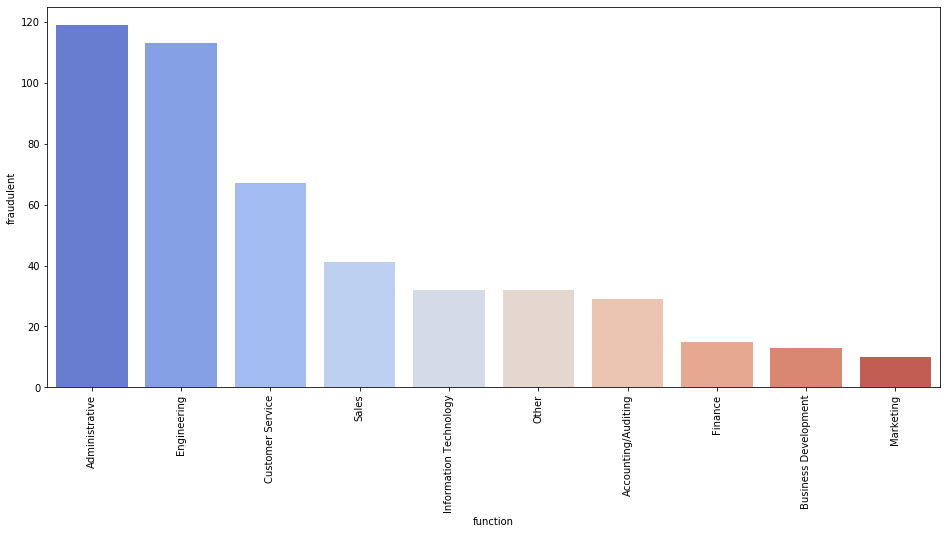

In [48]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,7))
ax.set_xticklabels(s, rotation='vertical')
s=data.loc[data['fraudulent']==1].groupby('function')['fraudulent'].count().sort_values(ascending=False)
s=s.head(10)
#print(s,'\n')
sns.barplot(x=s.index,y=s, palette='coolwarm',ax=ax)

# Train Test Split

In [118]:
x_train, x_test, y_train,y_test= train_test_split(data.drop('fraudulent',axis=1),data['fraudulent'],test_size=0.30
                                                  ,random_state=0)

x_train.shape,x_test.shape, y_train.shape

((12516, 9), (5364, 9), (12516,))

In [119]:
x_train.dtypes

department             object
telecommuting          object
has_company_logo       object
has_questions          object
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
dtype: object

## Pipeline

In [120]:
# pipeline for basic imputation
# 0.017

fakejob_pipe = Pipeline([

             
   ('imputer_cat_freq',mdi.FrequentCategoryImputer(variables=['department','employment_type','industry','function',
                                                              'required_experience','required_education'])),
    
       # categorical encoding 
    ('encoder_rare_label_dept',
     RareLabelCategoricalEncoder(tol=0.004235,
                                    n_categories=10,
                                    variables=['department'])),
    
        
     ('encoder_rare_label_industry',RareLabelCategoricalEncoder(tol=0.02,
                                    n_categories=10,
                                    variables=['industry','function'])),
                                               
    ('categorical_encoder',
     OneHotCategoricalEncoder( top_categories=None,
                               variables=categorical, # we can select which variables to encode
                               drop_last=True)),

])

In [121]:
fakejob_pipe.fit(x_train,y_train)

Pipeline(memory=None,
         steps=[('imputer_cat_freq',
                 FrequentCategoryImputer(variables=['department',
                                                    'employment_type',
                                                    'industry', 'function',
                                                    'required_experience',
                                                    'required_education'])),
                ('encoder_rare_label_dept',
                 RareLabelCategoricalEncoder(n_categories=10, tol=0.004235,
                                             variables=['department'])),
                ('encoder_rare_label_industry',
                 RareLabelCategoricalEncoder(n_categories=10, tol=0.02,
                                             variables=['industry',
                                                        'function'])),
                ('categorical_encoder',
                 OneHotCategoricalEncoder(drop_last=True, top_categories=None,
     

In [122]:
X_test=fakejob_pipe.transform (x_test)
X_train=fakejob_pipe.transform(x_train)

In [49]:
pip install imblearn

Note: you may need to restart the kernel to use updated packages.


# Simple Data Models

## Naive Alogorithm

In [48]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score
model_dummy = DummyClassifier(strategy='stratified',random_state=123)
model_dummy.fit(X_train,y_train)
cv_scores = cross_val_score(model_dummy, X_train, y_train,scoring='roc_auc')
# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(cv_scores.mean()))
print()
# Check test data set performance
print("Naive Algorithm Test Performance: ", model_dummy.score(X_test,y_test))

Mean Cross-validation scores: 0.4947302186371939

Naive Algorithm Test Performance:  0.9095824011931395


## Logistic Regression

In [49]:
clf = LogisticRegression(max_iter=1000).fit(X_train, y_train)

cv_scores = cross_val_score(clf, X_train, y_train, scoring='roc_auc')

# Mean Cross validation Score
print("Mean Cross-validation scores: {}".format(cv_scores.mean()))
print()

# Print Co-efficients
print("Logistic.coef_:", clf.coef_)
print("Logistic.intercept_:", clf.intercept_)

# Check test data set performance
print("Logistic Train Performance: ", clf.score(X_train,y_train))
print("Logistic Test Performance: ", clf.score(X_test,y_test))


Mean Cross-validation scores: 0.865556789672872

Logistic.coef_: [[ 1.06372644e-01  8.97898238e-01 -9.87259673e-01  2.10454026e+00
  -5.48775776e-01  1.59830457e+00 -1.02634344e+00 -4.89684537e-01
   2.91518077e-01  3.50222630e-01  9.03508248e-01  9.08113216e-01
  -1.91966004e-01 -1.93639794e+00  2.06865393e-03 -2.32582288e+00
  -5.57011708e-01 -2.69358953e+00  2.49541600e-01 -3.27276261e-01
   1.99419024e-01  5.79575534e-01  1.58593282e+00 -8.28496456e-01
   7.69073973e-02  1.17943945e+00  1.97780581e-01 -4.30288541e-01
  -1.07921870e-01 -8.29777738e-01  3.17469113e-01 -4.81185310e-01
  -2.29782131e-01  7.39545498e-01 -2.67032502e-01 -1.52618707e-01
  -1.54789875e-01  1.86291591e-01  9.19005718e-02 -2.91115967e-01
  -8.49456942e-01 -3.92312491e-01  1.66981808e+00 -2.93800519e-01
  -2.44373532e+00 -3.33130448e-01 -3.30769126e-01]]
Logistic.intercept_: [-1.72218706]
Logistic Train Performance:  0.9517417705337169
Logistic Test Performance:  0.9599179716629381


## Ridge Regression

In [50]:
ridge = Ridge()

#define a list of parameters
param_ridge = {'alpha':[0.001, 0.01,0.20] }

grid_ridge = GridSearchCV(ridge, param_ridge, cv=10,scoring='roc_auc', return_train_score = True)
grid_ridge.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.4f}".format(grid_ridge.best_score_))

#find best parameters
print('Ridge parameters: ', grid_ridge.best_params_)


# Check test data set performance
print("Ridge Train Performance: ", grid_ridge.score(X_train,y_train))
print("Ridge Test Performance: ", grid_ridge.score(X_test,y_test))

Best Mean Cross-validation score: 0.8582
Ridge parameters:  {'alpha': 0.01}
Ridge Train Performance:  0.8627751089249048
Ridge Test Performance:  0.8421587703959955


## Lasso Regression

In [51]:
lasso = Lasso()

#define a list of parameters
param_lasso = {'alpha':[0.001, 0.01,0.20] }

grid_lasso = GridSearchCV(lasso, param_ridge, cv=10,scoring='roc_auc', return_train_score = True)
grid_lasso.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.4f}".format(grid_lasso.best_score_))

#find best parameters
print('Ridge parameters: ', grid_lasso.best_params_)


# Check test data set performance
print("Ridge Train Performance: ", grid_lasso.score(X_train,y_train))
print("Ridge Test Performance: ", grid_lasso.score(X_test,y_test))

Best Mean Cross-validation score: 0.8443
Ridge parameters:  {'alpha': 0.001}
Ridge Train Performance:  0.846635170118124
Ridge Test Performance:  0.8339017527671322


## Elastic Net

In [107]:
from sklearn.linear_model import ElasticNet
elasticnet = ElasticNet()

#define a list of parameters
param_elasticnet = {'alpha':[0.001, 0.01,0.20], 'l1_ratio' :[0.001, 0.01,0.20]}

grid_elasticnet = GridSearchCV(elasticnet , param_elasticnet, cv=10, return_train_score = True)
grid_elasticnet.fit(X_train, y_train)

grid_elasticnet_train_score = grid_elasticnet.score(X_train, y_train)
grid_elasticnet_test_score = grid_elasticnet.score(X_test, y_test)

# Find Best parameters
print('Best parameters: ', grid_elasticnet.best_params_)
print('Best cross-validation score:', grid_elasticnet.best_score_)
print()
# Performance
print('Training set score: ', grid_elasticnet_train_score)
print('Test score: ', grid_elasticnet_test_score)




Best parameters:  {'alpha': 0.001, 'l1_ratio': 0.001}
Best cross-validation score: 0.11646492980181855

Training set score:  0.12489338567852638
Test score:  0.09755978134690091


## KNN

In [56]:
knn = KNeighborsClassifier()

# define a list of parameters

param_knn = {'n_neighbors': range(1,5)}

#apply grid search
grid_knn = GridSearchCV(knn, param_knn, cv=10, n_jobs=2, scoring='roc_auc')
grid_knn.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.4f}".format(grid_knn.best_score_))
print()

#find best parameters
print('KNN parameters: ', grid_knn.best_params_)

# Check train data set performance
print("KNN Train Performance: ", grid_knn.score(X_train,y_train))

# Check test data set performance
print("KNN Test Performance: ", grid_knn.score(X_test,y_test))

Best Mean Cross-validation score: 0.7966

KNN parameters:  {'n_neighbors': 4}
KNN Train Performance:  0.8544179957237744
KNN Test Performance:  0.8043845333886747


## Decision Tree

In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state=0)

#define a list of parameters
param_dtree = {'max_depth': range(1,20)}

#apply grid search
grid_dtree = GridSearchCV(dtree, param_dtree, cv=10, return_train_score = True, scoring = 'roc_auc')
grid_dtree.fit(X_train, y_train)

# Mean Cross Validation Score
print("Best Mean Cross-validation score: {:.4f}".format(grid_dtree.best_score_))
print()

#find best parameters
print('Decision Tree parameters: ', grid_dtree.best_params_)

# Check test data set performance
print("Decision Tree Performance: ", grid_dtree.score(X_train,y_train))

# Check test data set performance
print("Decision Tree Performance: ", grid_dtree.score(X_test,y_test))

Best Mean Cross-validation score: 0.8698

Decision Tree parameters:  {'max_depth': 10}
Decision Tree Performance:  0.9404839880027454
Decision Tree Performance:  0.8677067727525708


## SVM

In [ ]:
from sklearn import svm
supvm = svm.SVC(random_state=0)
C = [0.1, 1, 10]
param_svm = [{'kernel': ['rbf'],
              'C': C,
              'gamma': [0.01, 0.1, 1]},
             {'kernel': ['linear'],
              'C': C}]

grid_svm = GridSearchCV(supvm, param_svm, cv=5,
return_train_score=True,scoring = 'roc_auc')
grid_svm.fit(X_train, y_train)

In [ ]:
print('train score: ', grid_svm.score(X_train, y_train))
print('test score: ', grid_svm.score(X_train, y_train))
print("Best parameters: {}".format(grid_svm.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_svm.best_score_))

# Ensemble Models

## Bagging

In [27]:
bag_dtree = BaggingClassifier(DecisionTreeClassifier(max_depth= 8, max_leaf_nodes=5, min_samples_split= 3, 
                                                     splitter= 'random'), bootstrap=True, random_state=0, 
                              oob_score=True)

bag_dtree_param = {
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
bag_dtree_grid = GridSearchCV(bag_dtree, bag_dtree_param,cv=5, return_train_score=True, )
bag_dtree_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                               class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=8,
                                                                               max_features=None,
                                                                               max_leaf_nodes=5,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                               

In [33]:
print(f'Best Mean Cross Validation Score is {bag_dtree_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {bag_dtree_grid.best_params_}')
print(f'Train score is {bag_dtree_grid.score(X_train,y_train)}')
print(f'Test score is {bag_dtree_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.9519813603867053
Best Mean Cross Validation Score is {'max_samples': 0.8, 'n_estimators': 100}
Train score is 0.953579418344519
Test score is 0.9634601043997018


## Pasting

In [28]:
paste_dtree = BaggingClassifier(DecisionTreeClassifier(max_depth= 8, max_leaf_nodes=5, min_samples_split= 3, 
                                                     splitter= 'random'), bootstrap=False, random_state=0, 
                              oob_score=True)

bag_dtree_param = {
                 'max_samples':  [0.8,1],
                 'n_estimators': [10,25,100]}
paste_dtree_grid = GridSearchCV(bag_dtree, bag_dtree_param,cv=5, return_train_score=True, )
paste_dtree_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                               class_weight=None,
                                                                               criterion='gini',
                                                                               max_depth=8,
                                                                               max_features=None,
                                                                               max_leaf_nodes=5,
                                                                               min_impurity_decrease=0.0,
                                                                               min_impurity_split=None,
                                                                               min_samples_leaf=1,
                                                                               

In [29]:
print(f'Best Mean Cross Validation Score is {paste_dtree_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {paste_dtree_grid.best_params_}')
print(f'Train score is {paste_dtree_grid.score(X_train,y_train)}')
print(f'Test score is {paste_dtree_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.9519813603867053
Best Mean Cross Validation Score is {'max_samples': 0.8, 'n_estimators': 100}
Train score is 0.953579418344519
Test score is 0.9634601043997018


## Random Forrest

In [179]:
from sklearn.ensemble import RandomForestClassifier
rfc =RandomForestClassifier(random_state=42,oob_score=True)
rfc_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
    
    'criterion' :['gini', 'entropy']
}

rfc_grid = GridSearchCV(rfc, rfc_param,cv=5, return_train_score=True, )
rfc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=True, random_state=42,
                                   

In [36]:
rfc_grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__bootstrap', 'estimator__ccp_alpha', 'estimator__class_weight', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__max_samples', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [180]:
print(f'Best Mean Cross Validation Score is {rfc_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {rfc_grid.best_params_}')
print(f'Train score is {rfc_grid.score(X_train,y_train)}')
print(f'Test score is {rfc_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.9527005931540298
Best Mean Cross Validation Score is {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Train score is 0.9534196228827101
Test score is 0.9606636838180462


## Extra Trees

In [60]:
from  sklearn.ensemble import ExtraTreesClassifier
etc= ExtraTreesClassifier(random_state=42)
etc_param = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [2,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
etc_grid = GridSearchCV(etc, etc_param,cv=5, return_train_score=True, )
etc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                            class_weight=None, criterion='gini',
                                            max_depth=None, max_features='auto',
                                            max_leaf_nodes=None,
                                            max_samples=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=100, n_jobs=None,
                                            oob_score=False, random_state=42,
                                            verbose=0, warm_start=False),
             iid='deprecated'

In [38]:
etc_grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__bootstrap', 'estimator__ccp_alpha', 'estimator__class_weight', 'estimator__criterion', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__max_samples', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__oob_score', 'estimator__random_state', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [61]:
print(f'Best Mean Cross Validation Score is {etc_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {etc_grid.best_params_}')
print(f'Train score is {etc_grid.score(X_train,y_train)}')
print(f'Test score is {etc_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.9530201457930995
Best Mean Cross Validation Score is {'criterion': 'gini', 'max_depth': 8, 'max_features': 'auto', 'n_estimators': 500}
Train score is 0.9534995206136145
Test score is 0.9606636838180462


## Ada Boost

In [62]:
from sklearn.ensemble import AdaBoostClassifier
adc_dtree =AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),random_state=42)
adc_dtree_param = {
              'base_estimator__criterion' : ["gini", "entropy"],
              'base_estimator__splitter' :   ["best", "random"],
              'base_estimator__max_depth' : [2,4,6],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2],
             }
adc_dtree_grid = GridSearchCV(adc_dtree, adc_dtree_param,cv=5, return_train_score=True, )
adc_dtree_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
 

In [40]:
adc_dtree_grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__algorithm', 'estimator__base_estimator__ccp_alpha', 'estimator__base_estimator__class_weight', 'estimator__base_estimator__criterion', 'estimator__base_estimator__max_depth', 'estimator__base_estimator__max_features', 'estimator__base_estimator__max_leaf_nodes', 'estimator__base_estimator__min_impurity_decrease', 'estimator__base_estimator__min_impurity_split', 'estimator__base_estimator__min_samples_leaf', 'estimator__base_estimator__min_samples_split', 'estimator__base_estimator__min_weight_fraction_leaf', 'estimator__base_estimator__presort', 'estimator__base_estimator__random_state', 'estimator__base_estimator__splitter', 'estimator__base_estimator', 'estimator__learning_rate', 'estimator__n_estimators', 'estimator__random_state', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [63]:
print(f'Best Mean Cross Validation Score is {adc_dtree_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {adc_dtree_grid.best_params_}')
print(f'Train score is {adc_dtree_grid.score(X_train,y_train)}')
print(f'Test score is {adc_dtree_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.9574145211050255
Best Mean Cross Validation Score is {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 6, 'base_estimator__splitter': 'random', 'learning_rate': 0.5, 'n_estimators': 100}
Train score is 0.9721156919143497
Test score is 0.9679343773303505


## Gradient Boost

In [64]:
from  sklearn.ensemble import GradientBoostingClassifier
gbc= GradientBoostingClassifier(random_state=42)
gbc_param = {
              'max_depth' : [2,3,4],
              'n_estimators' : [100,150],
              'learning_rate' : [0.5,1.0,2],
             }
gbc_grid = GridSearchCV(gbc, gbc_param,cv=5, return_train_score=True, )
gbc_grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
         

In [42]:
gbc_grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__ccp_alpha', 'estimator__criterion', 'estimator__init', 'estimator__learning_rate', 'estimator__loss', 'estimator__max_depth', 'estimator__max_features', 'estimator__max_leaf_nodes', 'estimator__min_impurity_decrease', 'estimator__min_impurity_split', 'estimator__min_samples_leaf', 'estimator__min_samples_split', 'estimator__min_weight_fraction_leaf', 'estimator__n_estimators', 'estimator__n_iter_no_change', 'estimator__presort', 'estimator__random_state', 'estimator__subsample', 'estimator__tol', 'estimator__validation_fraction', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [106]:
print(f'Best Mean Cross Validation Score is {gbc_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {gbc_grid.best_params_}')
print(f'Train score is {gbc_grid.score(X_train,y_train)}')
print(f'Test score is {gbc_grid.score(X_test,y_test)}')


Best Mean Cross Validation Score is 0.9554170139602445
Best Mean Cross Validation Score is {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 150}
Train score is 0.9653243847874721
Test score is 0.9623415361670395


## XGBoost

In [66]:
from xgboost import XGBClassifier
from  xgboost import XGBClassifier
xgbc= XGBClassifier(random_state=42,early_stopping_rounds=2,objective= 'binary:logistic')
xgbc_param = {
              'max_depth' : [2,4,6],
              'n_estimators' : [50,100,150],
              'learning_rate' : [0.1,0.5,0.6,0.8],
               'min_child_weight' : [1,3,5,7],
                'subsample':[0.6,0.7,0.8,0.9,1]
             }
xgbc_grid = GridSearchCV(xgbc, xgbc_param,cv=5, return_train_score=True, )


In [45]:
xgbc_grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__objective', 'estimator__base_score', 'estimator__booster', 'estimator__colsample_bylevel', 'estimator__colsample_bynode', 'estimator__colsample_bytree', 'estimator__gamma', 'estimator__gpu_id', 'estimator__importance_type', 'estimator__interaction_constraints', 'estimator__learning_rate', 'estimator__max_delta_step', 'estimator__max_depth', 'estimator__min_child_weight', 'estimator__missing', 'estimator__monotone_constraints', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__num_parallel_tree', 'estimator__random_state', 'estimator__reg_alpha', 'estimator__reg_lambda', 'estimator__scale_pos_weight', 'estimator__subsample', 'estimator__tree_method', 'estimator__validate_parameters', 'estimator__verbosity', 'estimator__early_stopping_rounds', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [68]:
xgbc_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {xgbc_grid.best_score_}')
print(f'Best Mean Cross Validation Score is {xgbc_grid.best_params_}')
print(f'Train score is {xgbc_grid.score(X_train,y_train)}')
print(f'Test score is {xgbc_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.957734137565273
Best Mean Cross Validation Score is {'learning_rate': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.7}
Train score is 0.9688398849472675
Test score is 0.9666293810589113


# Cost Sensitive Algorithms

In [84]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

# # Logistic Regresion

In [101]:
param_grid = {
'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
    'penalty':['l1','l2'],
}
#apply grid search
cgrid_logreg= GridSearchCV(LogisticRegression(solver='lbfgs'), param_grid, cv=10, n_jobs=-1, scoring='roc_auc')
cgrid_logreg.fit(X_train, y_train)
print("Best parameters: {}".format(cgrid_logreg.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cgrid_logreg.best_score_))

Best parameters: {'class_weight': {0: 1, 1: 10}, 'penalty': 'l2'}
Best Mean cross-validation score: 0.87


In [80]:
cgrid_logreg.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__l1_ratio', 'estimator__max_iter', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__penalty', 'estimator__random_state', 'estimator__solver', 'estimator__tol', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

## SVC

In [102]:
param_grid = {
'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
}
#apply grid search
cgrid_svc= GridSearchCV(SVC(), param_grid, cv=10, n_jobs=-1, scoring='roc_auc')
cgrid_svc.fit(X_train, y_train)
print("Best parameters: {}".format(cgrid_svc.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cgrid_svc.best_score_))

Best parameters: {'class_weight': {0: 1, 1: 10}}
Best Mean cross-validation score: 0.90


In [89]:
cgrid_svc.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__C', 'estimator__break_ties', 'estimator__cache_size', 'estimator__class_weight', 'estimator__coef0', 'estimator__decision_function_shape', 'estimator__degree', 'estimator__gamma', 'estimator__kernel', 'estimator__max_iter', 'estimator__probability', 'estimator__random_state', 'estimator__shrinking', 'estimator__tol', 'estimator__verbose', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

## Decision Tree

In [103]:
#decison tree
param_grid = {
'class_weight': [{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
}
#apply grid search
cgrid_dtree= GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, n_jobs=-1, scoring='roc_auc')
cgrid_dtree.fit(X_train, y_train)
print("Best parameters: {}".format(cgrid_dtree.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cgrid_dtree.best_score_))

Best parameters: {'class_weight': {0: 10, 1: 1}}
Best Mean cross-validation score: 0.85


In [ ]:
cgrid_dtree.get_params().keys()

## XG BOOST

In [104]:
param_grid = {
'scale_pos_weight': [1, 10, 25, 50, 75, 99, 100, 1000],
}
#apply grid search
cgrid_xgboost= GridSearchCV(XGBClassifier(), param_grid, cv=10, n_jobs=-1, scoring='roc_auc')
cgrid_xgboost.fit(X_train, y_train)
print("Best parameters: {}".format(cgrid_xgboost.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(cgrid_xgboost.best_score_))

Best parameters: {'scale_pos_weight': 1}
Best Mean cross-validation score: 0.92


In [97]:
cgrid_xgboost.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__objective', 'estimator__base_score', 'estimator__booster', 'estimator__colsample_bylevel', 'estimator__colsample_bynode', 'estimator__colsample_bytree', 'estimator__gamma', 'estimator__gpu_id', 'estimator__importance_type', 'estimator__interaction_constraints', 'estimator__learning_rate', 'estimator__max_delta_step', 'estimator__max_depth', 'estimator__min_child_weight', 'estimator__missing', 'estimator__monotone_constraints', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__num_parallel_tree', 'estimator__random_state', 'estimator__reg_alpha', 'estimator__reg_lambda', 'estimator__scale_pos_weight', 'estimator__subsample', 'estimator__tree_method', 'estimator__validate_parameters', 'estimator__verbosity', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

## Random Forest

In [151]:
from sklearn.model_selection import RepeatedStratifiedKFold
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_rf = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % scores_rf.mean())

Mean ROC AUC: 0.897


# Extra Trees

In [150]:
rf = ExtraTreesClassifier(n_estimators=50, class_weight='balanced')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_etc = cross_val_score(rf, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % scores_etc.mean())

Mean ROC AUC: 0.882


## Bagging Decision Tree

In [152]:
from imblearn.ensemble import BalancedBaggingClassifier
b_dtree = BalancedBaggingClassifier()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores_btree = cross_val_score(b_dtree, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % scores_btree.mean())

Mean ROC AUC: 0.914


# Data Sampling Algorithm

SMOTE

In [109]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## Logistic Regression

In [136]:
#logistic regression
pipe_roc_lg = Pipeline([('smote',SMOTE()),('lg',LogisticRegression())])
param_roc_lg = {'smote__k_neighbors': [1,2,3,4,5]}
logrid_lg= GridSearchCV(pipe_roc_lg,param_roc_lg, cv=10, n_jobs=-1, scoring='roc_auc')
logrid_lg.fit(X_train, y_train)
print("Best parameters: {}".format(logrid_lg.best_params_))
print("Best Mean cross-validation score: {:.4f}".format(logrid_lg.best_score_))

Best parameters: {'smote__k_neighbors': 1}
Best Mean cross-validation score: 0.8637


In [111]:
logrid_lg.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__smote', 'estimator__lg', 'estimator__smote__k_neighbors', 'estimator__smote__n_jobs', 'estimator__smote__random_state', 'estimator__smote__sampling_strategy', 'estimator__lg__C', 'estimator__lg__class_weight', 'estimator__lg__dual', 'estimator__lg__fit_intercept', 'estimator__lg__intercept_scaling', 'estimator__lg__l1_ratio', 'estimator__lg__max_iter', 'estimator__lg__multi_class', 'estimator__lg__n_jobs', 'estimator__lg__penalty', 'estimator__lg__random_state', 'estimator__lg__solver', 'estimator__lg__tol', 'estimator__lg__verbose', 'estimator__lg__warm_start', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

## Ridge Regression using SMOTE

In [115]:
pipe_rand_smote = Pipeline([('smote', SMOTE()), ('model', Ridge())])
param_grid = {
    # try different feature engineering parameters
    'smote__k_neighbors': range(1,10),
    #'model__n_neighbors’':range(1,5),
    #'model__max_depth': [2,3,4,5,6],
    #'model__alpha': [0.1,1,10,100,80,70]
    'model__alpha': range(60,88,1)
}

#apply grid search
gridridge_smote= GridSearchCV(pipe_rand_smote, param_grid, cv=5, n_jobs=2, scoring='roc_auc')
gridridge_smote.fit(X_train, y_train)

print("Best parameters: {}".format(gridridge_smote.best_params_))
print("Best Mean cross-validation score: {:.4f}".format(gridridge_smote.best_score_))

Best parameters: {'model__alpha': 60, 'smote__k_neighbors': 1}
Best Mean cross-validation score: 0.8654


In [ ]:
gridridge_smote.get_params().keys()

## KNN regression using SMOTE


In [48]:
pipe_rand_smote = Pipeline([('smote', SMOTE()), ('model', KNeighborsClassifier())])
param_grid = {
    # try different feature engineering parameters
    'smote__k_neighbors': range(1,10),
    #'model__n_neighbors’':range(1,5),
    #'model__max_depth': [2,3,4,5,6],
}

#apply grid search
grid_smote= GridSearchCV(pipe_rand_smote, param_grid, cv=5, n_jobs=2, scoring='roc_auc')
grid_smote.fit(X_train, y_train)

print("Best parameters: {}".format(grid_smote.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(grid_smote.best_score_))


Best parameters: {'smote__k_neighbors': 6}
Best Mean cross-validation score: 0.85


In [49]:
print("KNN Train Performance: ", grid_smote.score(X_train,y_train))


# Check test data set performance
print("KNN Test Performance: ", grid_smote.score(X_test,y_test))

KNN Train Performance:  0.9138722769103182
KNN Test Performance:  0.8760542629742415


## Lasso Regression Using Smote

In [106]:
pipe_rand_smote = Pipeline([('smote', SMOTE()), ('model', Lasso())])
param_grid = {
    # try different feature engineering parameters
    #'smote__k_neighbors': range(1,10),
    #'model__n_neighbors’':range(1,5),
    #'model__max_depth': [2,3,4,5,6],
    'model__alpha':[0.001,0.1,1,10],
    
}

#apply grid search
grid_smote= GridSearchCV(pipe_rand_smote, param_grid, cv=10, n_jobs=-1, scoring='roc_auc')
grid_smote.fit(X_train, y_train)

print("Best parameters: {}".format(grid_smote.best_params_))
print("Best Mean cross-validation score: {:.4f}".format(grid_smote.best_score_))

Best parameters: {'model__alpha': 0.001}
Best Mean cross-validation score: 0.8637


In [91]:
grid_smote.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__smote', 'estimator__model', 'estimator__smote__k_neighbors', 'estimator__smote__n_jobs', 'estimator__smote__random_state', 'estimator__smote__sampling_strategy', 'estimator__model__alpha', 'estimator__model__copy_X', 'estimator__model__fit_intercept', 'estimator__model__max_iter', 'estimator__model__normalize', 'estimator__model__positive', 'estimator__model__precompute', 'estimator__model__random_state', 'estimator__model__selection', 'estimator__model__tol', 'estimator__model__warm_start', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

## Decision tree

In [123]:
pipe_roc_dtree = Pipeline([('smote',SMOTE()),('dtree',DecisionTreeClassifier(max_depth=5))])
param_roc_dtree = {'smote__k_neighbors': [1,2,3,4,5],
                 'dtree__max_leaf_nodes': [10,20],
                   'dtree__max_depth':[10,20,40]
                  }
ogrid_dtree= GridSearchCV(pipe_roc_dtree,param_roc_dtree, cv=10, n_jobs=2, scoring='roc_auc')
ogrid_dtree.fit(X_train, y_train)
print("Best parameters: {}".format(ogrid_dtree.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ogrid_dtree.best_score_))

Best parameters: {'dtree__max_depth': 10, 'dtree__max_leaf_nodes': 20, 'smote__k_neighbors': 3}
Best Mean cross-validation score: 0.86


In [117]:
ogrid_dtree.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__smote', 'estimator__dtree', 'estimator__smote__k_neighbors', 'estimator__smote__n_jobs', 'estimator__smote__random_state', 'estimator__smote__sampling_strategy', 'estimator__dtree__ccp_alpha', 'estimator__dtree__class_weight', 'estimator__dtree__criterion', 'estimator__dtree__max_depth', 'estimator__dtree__max_features', 'estimator__dtree__max_leaf_nodes', 'estimator__dtree__min_impurity_decrease', 'estimator__dtree__min_impurity_split', 'estimator__dtree__min_samples_leaf', 'estimator__dtree__min_samples_split', 'estimator__dtree__min_weight_fraction_leaf', 'estimator__dtree__presort', 'estimator__dtree__random_state', 'estimator__dtree__splitter', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

## Randomforest

In [176]:
pipe_roc_rf = Pipeline([('smote',SMOTE()),('rf',RandomForestClassifier(n_estimators=100,criterion='gini',
                                                                       max_features='auto'))])
param_roc_rf = {'smote__k_neighbors': [4,5,10,20,50,70,100], 
                'rf__max_depth' : [4,5,10,20,30]
               }
ogrid_rf= GridSearchCV(pipe_roc_rf,param_roc_rf, cv=10, n_jobs=-1, scoring='roc_auc')
ogrid_rf.fit(X_train, y_train)
print("Best parameters: {}".format(ogrid_rf.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ogrid_rf.best_score_))

Best parameters: {'rf__max_depth': 20, 'smote__k_neighbors': 5}
Best Mean cross-validation score: 0.91


In [126]:
ogrid_rf.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__smote', 'estimator__rf', 'estimator__smote__k_neighbors', 'estimator__smote__n_jobs', 'estimator__smote__random_state', 'estimator__smote__sampling_strategy', 'estimator__rf__bootstrap', 'estimator__rf__ccp_alpha', 'estimator__rf__class_weight', 'estimator__rf__criterion', 'estimator__rf__max_depth', 'estimator__rf__max_features', 'estimator__rf__max_leaf_nodes', 'estimator__rf__max_samples', 'estimator__rf__min_impurity_decrease', 'estimator__rf__min_impurity_split', 'estimator__rf__min_samples_leaf', 'estimator__rf__min_samples_split', 'estimator__rf__min_weight_fraction_leaf', 'estimator__rf__n_estimators', 'estimator__rf__n_jobs', 'estimator__rf__oob_score', 'estimator__rf__random_state', 'estimator__rf__verbose', 'estimator__rf__warm_start', 'estimator', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [183]:
print("Train Score",ogrid_rf.score(X_train, y_train))

print("Test Score",ogrid_rf.score(X_test, y_test))

Train Score 0.9628272474132682
Test Score 0.9213638807682709


##  SVM

In [ ]:
pipe_roc_svm = Pipeline([('smote',SMOTE()),('svm',svm.SVC(C=10,gamma=0.1,kernel='rbf'))])
param_roc_svm = {'smote__k_neighbors': [1,2,3,4,5]}
ogrid_svm= GridSearchCV(pipe_roc_svm,param_roc_svm, cv=10, n_jobs=-1, scoring='roc_auc')
ogrid_svm.fit(X_train, y_train)
print("Best parameters: {}".format(ogrid_svm.best_params_))
print("Best Mean cross-validation score: {:.2f}".format(ogrid_svm.best_score_))

## XGB

In [135]:
pipe_roc_xgb = Pipeline([('smote',SMOTE()),('xgb',XGBClassifier(random_state=42,
                                                                early_stopping_rounds=2,
                                                                n_estimators=100,
                                                                objective ='binary:logistic',
                                                                max_depth = 4,
                                                               ))])
param_roc_xgb = {'smote__k_neighbors': [1,2,3,4,5],
'xgb__learning_rate' : [0.1,0.5]}
ogrid_xgb= GridSearchCV(pipe_roc_xgb,param_roc_xgb, cv=10, n_jobs=-1, scoring='roc_auc')
ogrid_xgb.fit(X_train, y_train)
print("Best parameters: {}".format(ogrid_xgb.best_params_))
print("Best Mean cross-validation score: {:.4f}".format(ogrid_xgb.best_score_))

Best parameters: {'smote__k_neighbors': 4, 'xgb__learning_rate': 0.1}
Best Mean cross-validation score: 0.90


# Top models

In [162]:
classifiers={'knn': grid_knn,
            'dtree':grid_dtree,
             'bag_dtree':bag_dtree_grid,         
            'paste_dtree': paste_dtree_grid,
            'rfc': rfc_grid,
             'etc': etc_grid,
             'adc_dtree':adc_dtree_grid,
             'gbc': gbc_grid,
             'xgbc': xgbc_grid,
            'Elastic':grid_elasticnet,
             'Ridge':grid_ridge,
             'Lasso':grid_lasso,
             'XGB Smote':ogrid_xgb,
             'rfc_smote':ogrid_rf,
             'ridge_smote':gridridge_smote,
             'tree_smote':ogrid_dtree,
             'cost_logistic':cgrid_logreg,
             'cost_svc':cgrid_svc,
             'cost_tree':cgrid_dtree,
             'cost_xgboost':cgrid_xgboost,
             
            }

In [163]:
results_mean_std = []
for  key, value in classifiers.items():
    mean = value.cv_results_['mean_test_score'][value.best_index_]
    std=value.cv_results_['std_test_score'][value.best_index_]
     
    results_mean_std.append({
        "model": key,
        "mean": mean,
        "std": std
    })

In [164]:
# Create a Pandas DataFrame with the mean+std results
accuracy_df = pd.DataFrame(results_mean_std, columns=['model', 'mean', 'std'])

In [165]:
# Show the accuracy dataframe

accuracy_df.sort_values(by=['mean'], inplace=True,ascending=False)
accuracy_df

,model,mean,std
8,xgbc,0.957734,0.003495
6,adc_dtree,0.957415,0.002996
7,gbc,0.955417,0.003233
5,etc,0.953020,0.001442
4,rfc,0.952701,0.001441
2,bag_dtree,0.951981,0.001589
3,paste_dtree,0.951981,0.001589
19,cost_xgboost,0.917265,0.012525
13,rfc_smote,0.903501,0.013991
17,cost_svc,0.903121,0.014274


In [142]:
# Create a prediction of all models on the test set
predictions_all = {}
for  key, value in classifiers.items():
    # Get best estimator
    best_model = value.best_estimator_
    
    # Predict test labels
    predictions = best_model.predict(X_test)
    
    # Save predictions to a list
    predictions_all[key] = predictions

In [143]:
pred = pd.DataFrame(predictions_all)

Text(0.5, 1, 'Correlation of the test set label prediction between models')

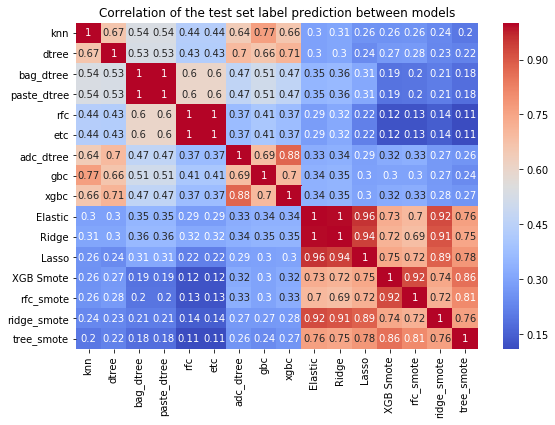

In [144]:
# Plot a heatmap of all correlations for easier visualization
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(9,6))
g = sns.heatmap(pred.corr(), annot=True, cmap='coolwarm', ax=ax)
g.set_title('Correlation of the test set label prediction between models')

In [145]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=True)
    return au_corr[0:n]

In [146]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(pred, 5))

Top Absolute Correlations
rfc  tree_smote    0.109838
etc  tree_smote    0.109838
rfc  XGB Smote     0.124444
etc  XGB Smote     0.124444
rfc  rfc_smote     0.126478
dtype: float64


## Stacking

In [166]:
#top 5 estimators
estimators_ = [('XGBC',xgbc_grid.best_estimator_),
('Ada Boost',adc_dtree_grid.best_estimator_),('GBC',gbc_grid.best_estimator_),
('Extra Trees',etc_grid.best_estimator_),('Random Forrest',rfc_grid.best_estimator_)]

In [172]:
from sklearn.ensemble import StackingClassifier
sclf2 = StackingClassifier(estimators= estimators_, 
                           final_estimator=LogisticRegression())
sclf2_param = {'final_estimator__C' : [0.1,0.2],
               'stack_method':['auto']
              }

sclf2_grid = GridSearchCV(sclf2, sclf2_param,cv=10, return_train_score=True,scoring='roc_auc' )
sclf2_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {sclf2_grid.best_score_}')
print(f'Best Mean Cross Validation params is {sclf2_grid.best_params_}')
print(f'Train score is {sclf2_grid.score(X_train,y_train)}')
print(f'Test score is {sclf2_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.902891367359539
Best Mean Cross Validation params is {'final_estimator__C': 0.2, 'stack_method': 'auto'}
Train score is 0.9699396645559605
Test score is 0.9247255164441441


In [171]:
from sklearn.ensemble import StackingClassifier
sclf2 = StackingClassifier(estimators= estimators_, 
                           final_estimator=XGBClassifier())
sclf2_param = {'final_estimator__C' : [0.1,0.2],
               'stack_method':['auto']
              }

sclf2_grid = GridSearchCV(sclf2, sclf2_param,cv=10, return_train_score=True,scoring='roc_auc' )
sclf2_grid.fit(X_train,y_train)
print(f'Best Mean Cross Validation Score is {sclf2_grid.best_score_}')
print(f'Best Mean Cross Validation params is {sclf2_grid.best_params_}')
print(f'Train score is {sclf2_grid.score(X_train,y_train)}')
print(f'Test score is {sclf2_grid.score(X_test,y_test)}')

Best Mean Cross Validation Score is 0.9100134401167036
Best Mean Cross Validation params is {'final_estimator__C': 0.1, 'stack_method': 'auto'}
Train score is 0.9509360617692855
Test score is 0.9193606203246895


In [169]:
sclf2_grid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__cv', 'estimator__estimators', 'estimator__final_estimator__C', 'estimator__final_estimator__class_weight', 'estimator__final_estimator__dual', 'estimator__final_estimator__fit_intercept', 'estimator__final_estimator__intercept_scaling', 'estimator__final_estimator__l1_ratio', 'estimator__final_estimator__max_iter', 'estimator__final_estimator__multi_class', 'estimator__final_estimator__n_jobs', 'estimator__final_estimator__penalty', 'estimator__final_estimator__random_state', 'estimator__final_estimator__solver', 'estimator__final_estimator__tol', 'estimator__final_estimator__verbose', 'estimator__final_estimator__warm_start', 'estimator__final_estimator', 'estimator__n_jobs', 'estimator__passthrough', 'estimator__stack_method', 'estimator__verbose', 'estimator__XGBC', 'estimator__Ada Boost', 'estimator__GBC', 'estimator__Extra Trees', 'estimator__Random Forrest', 'estimator__XGBC__objective', 'estimator__XGBC__base_score', 'estimator__XGBC__